# Rag - Hybrid Search Practice and for more check deeplearning.ai

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
from datasets import load_dataset
from pinecone_text.sparse import BM25Encoder
from pinecone import Pinecone, ServerlessSpec
import pinecone
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import torch
import os

In [9]:
PINECONE_API_KEY=os.environ["PINECONE_API_KEY"]

## Possible error:
 - {"error":{"code":"INVALID_ARGUMENT","message":"Bad request: Your free plan does not support indexes in the us-west-2 region of aws. To create indexes in this region, upgrade your plan."},"status":400}
 => for this change the region as per free tier plan

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

INDEX_NAME = "hybridsearchedbasedrag"

pinecone = Pinecone(api_key=PINECONE_API_KEY)

if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  pinecone.delete_index(INDEX_NAME)

pinecone.create_index(
  INDEX_NAME,
  dimension=512,
  metric="dotproduct",
   spec=ServerlessSpec(cloud='aws', region='us-east-1')
)
index = pinecone.Index(INDEX_NAME)

cpu


In [12]:
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [13]:
images = fashion['image']
metadata = fashion.remove_columns('image')
images[900]
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


# Sparse Vector

In [14]:
bm25 = BM25Encoder()
bm25.fit(metadata['productDisplayName'])
metadata['productDisplayName'][0]

  0%|          | 0/44072 [00:00<?, ?it/s]

'Turtle Check Men Navy Blue Shirt'

# Dense Vector

In [15]:
model = SentenceTransformer('sentence-transformers/clip-ViT-B-32', 
    device=device)
model
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

(1, 512)

# Create emedings using Sparse And Dense

In [16]:
batch_size = 100
fashion_data_num = 1000 #smaller number to make it faster , try multiple values large and small

for i in tqdm(range(0, min(fashion_data_num,len(fashion)), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    
    # extract image batch
    img_batch = images[i:i_end]
    
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = [] #insertion array for pinecone 
   
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()

  0%|          | 0/10 [00:00<?, ?it/s]

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}

# Simple hybrid Search 

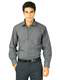

In [20]:
query = "dark blue saiyan suit for men"

sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)

imgs = [images[int(r["id"])] for r in result["matches"]]
imgs[0]

# Hybrid Scaling Search

In [21]:
def hybrid_scale(dense, sparse, alpha: float):
    """
    alpha * dense + (1 - alpha) * sparse

    alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
   
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

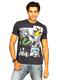

In [24]:
question = "dark blue saiyan suit for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
imgs[5]

